In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    AllocationMethod,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Loading BokehJS ...

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 60.99it/s]


['KDA-USDT',
 'ATOM-USDT',
 'ETC-USDT',
 'MATIC-USDT',
 'LINK-USDT',
 'BCH-USDT',
 'BNB-USDT',
 'ADA-USDT',
 'DOGE-USDT',
 'XTZ-USDT',
 'DASH-USDT',
 'AVAX-USDT',
 'VET-USDT',
 'ETH-USDT',
 'SOL-USDT',
 'EOS-USDT',
 'TRX-USDT',
 'XLM-USDT',
 'BTC-USDT',
 'XRP-USDT',
 'LTC-USDT']

In [2]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.RETURNS,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc[:]  # "2021-10-28"
)
universe.head()

price                                                            \
           KDA-USDT ATOM-USDT ETC-USDT MATIC-USDT LINK-USDT BCH-USDT BNB-USDT   
Date                                                                            
2021-09-02   0.7978   24.1422  67.6071     1.4453   29.9377   664.49  483.465   
2021-09-03   0.7902   24.1158  69.9936     1.4559   30.7581   713.32  488.472   
2021-09-04   0.7628   24.3884  68.7689     1.7374   29.8832   708.80  497.691   
2021-09-05   0.8571   25.7148  73.5208     1.6803   33.5289   765.00  504.940   
2021-09-06   1.0000   25.1007  73.4993     1.6435   34.8208   784.61  495.886   

                                         ...        volume                \
            ADA-USDT DOGE-USDT XTZ-USDT  ...     AVAX-USDT      VET-USDT   
Date                                     ...                               
2021-09-02  2.960618   0.29450  5.29412  ...  1.260635e+07  4.366786e+07   
2021-09-03  2.965665   0.29612  5.31364  ...  2.368620e+07  3.520757e+07   
2021-09-04  2.828828   0.29928  5.40328  ...  1.644097e+07  2.508443e+07   
2021-09-05  2.911501   0.31436  5.56640  ...  1.239841e+07  2.032786e+07   
2021-09-06  2.830175   0.30905  5.59636  ...  1.999695e+07  2.940524e+07   

                                                                    \
                ETH-USDT      SOL-USDT      EOS-USDT      TRX-USDT   
Date                                                                 
2021-09-02  2.377383e+08  3.756954e+07  8.027218e+06  1.228910e+07   
2021-09-03  2.619353e+08  5.825224e+07  1.095528e+07  1.120307e+07   
2021-09-04  1.661564e+08  3.278846e+07  1.176539e+07  7.332294e+06   
2021-09-05  1.646614e+08  2.985273e+07  1.376169e+07  7.281659e+06   
2021-09-06  1.615486e+08  4.597036e+07  1.304758e+07  6.844546e+06   

                                                                    
                XLM-USDT      BTC-USDT      XRP-USDT      LTC-USDT  
Date                                                                
2021-09-02  7.668948e+06  2.520587e+08  1.267274e+08  1.063425e+07  
2021-09-03  8.803225e+06  2.840126e+08  1.407533e+08  3.419287e+07  
2021-09-04  6.530082e+06  1.646118e+08  7.957580e+07  2.554847e+07  
2021-09-05  1.087278e+07  1.977992e+08  8.653651e+07  2.442621e+07  
2021-09-06  1.743378e+07  2.379977e+08  1.793894e+08  2.233272e+07  

[5 rows x 105 columns]

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


# Building a benchmark


## Capitalization weighted index


In [3]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-09-02,-0.004464,-0.006258,0.008882
2021-09-03,0.032272,0.026301,0.015474
2021-09-04,0.002686,-0.012745,-0.002168
2021-09-05,0.052077,0.034408,0.037381
2021-09-06,0.013265,0.010569,0.017370
...,...,...,...
2023-12-22,0.005080,0.001505,-0.007230
2023-12-23,0.001327,0.005436,0.004439
2023-12-24,0.054098,0.034923,0.000096


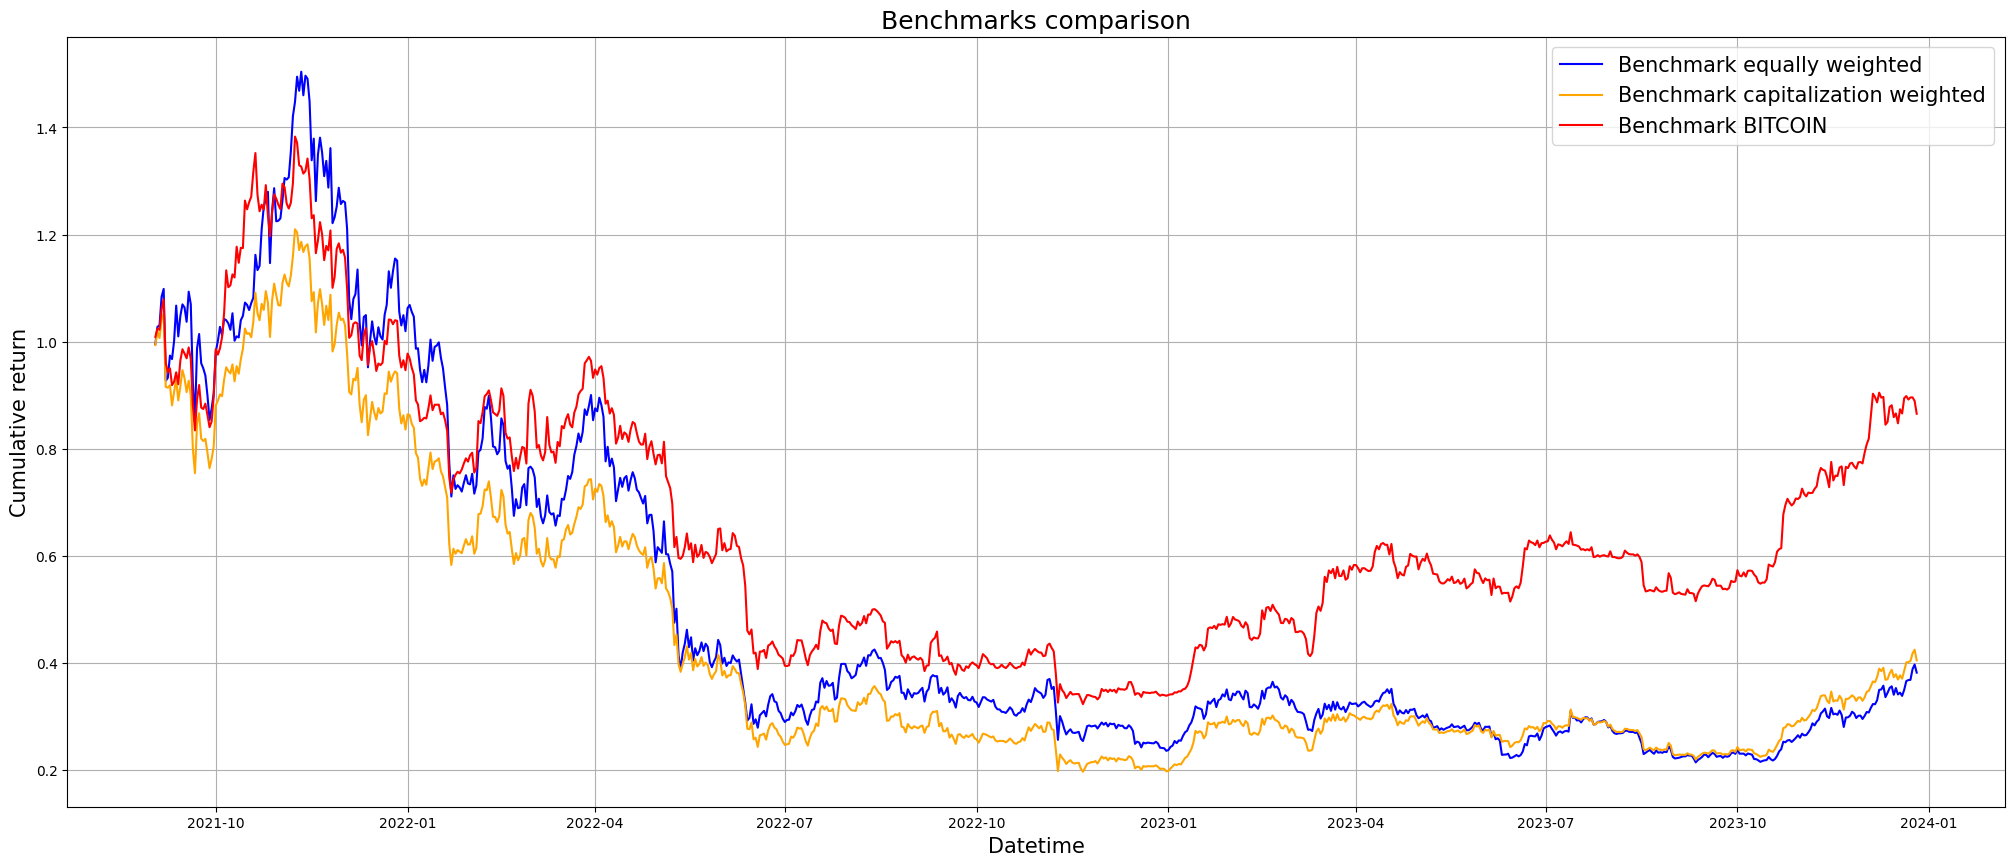

In [4]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper right", fontsize=15)
# ax.set_yscale("log")

# Backtesting strategies


## Backtesting with a benchmark and a strategy

In [11]:
ptf_backtester = PortfolioBacktester(universe=universe)

returns_capi, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
    verbose=False,
    print_stats=True,
    plot_curve=True,
)

Building the Benchmark...:   6%|▌         | 48/846 [00:00<00:01, 473.28it/s]


-------  Returns statistical information  --------
Expected return annualized: 88.53 % vs -17.75 % (buy and hold)
CAGR: 44.97 % vs -32.10 % (buy and hold)
Expected volatility annualized: 100.18 % vs 64.82 % (buy and hold)
Specific volatility (diversifiable) annualized: 68.74 %
Systematic volatility annualized: 72.87 %
Skewness: 0.76 vs -0.33 (buy and hold), <0 = left tail, >0 = right tail
Kurtosis: 5.87 vs -0.33 (buy and hold) , >3 = fat tails, <3 = thin tails
1day-95%-VaR: -7.64 % vs -5.73 % (buy and hold) -> the lower the better
1day-95%-CVaR: -11.19 % vs -8.39 % (buy and hold) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -90.67 % vs -83.71 % (buy and hold)
Kelly criterion: 6.55 % vs -2.04 % (buy and hold)
Benchmark sensitivity (beta): 1.12 vs 1 (buy and hold)
Excess return (alpha): 0.0030 vs 0 (buy and hold)
Jensen alpha: -0.0000
Determination coefficient R²: 0.53
Tracking error annualized: 69.21 %

---------------  Strategy ratios  ----

Loading BokehJS ...

Loading BokehJS ...

## Several strategies

In [6]:
ptf_backtester = PortfolioBacktester(universe=universe)

returns_capi, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_capi.name = "capitalization_weighted"

returns_rp, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.RISK_PARITY,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_rp.name = "risk_parity"
returns_mv, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_mv.name = "mean_variance"
returns, weights_df = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.EQUAL_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns.name = "equal_weighted"

In [7]:
returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
returns_df

,equal_weighted,capitalization_weighted,risk_parity,mean_variance
Date,,,,
2021-09-02,0.051898,0.048428,0.051898,0.051898
2021-09-03,0.021404,0.025321,0.021404,0.021404
2021-09-04,-0.020215,-0.039908,-0.020215,-0.020215
2021-09-05,0.048145,0.028879,0.048145,0.048145
2021-09-06,0.055352,0.011295,0.055352,0.055352
...,...,...,...,...
2023-12-22,-0.022944,-0.013139,-0.023133,-0.032070
2023-12-23,0.013767,0.022239,0.008581,0.019210
2023-12-24,0.058585,0.102083,0.044001,0.081115


### Plot all strategies

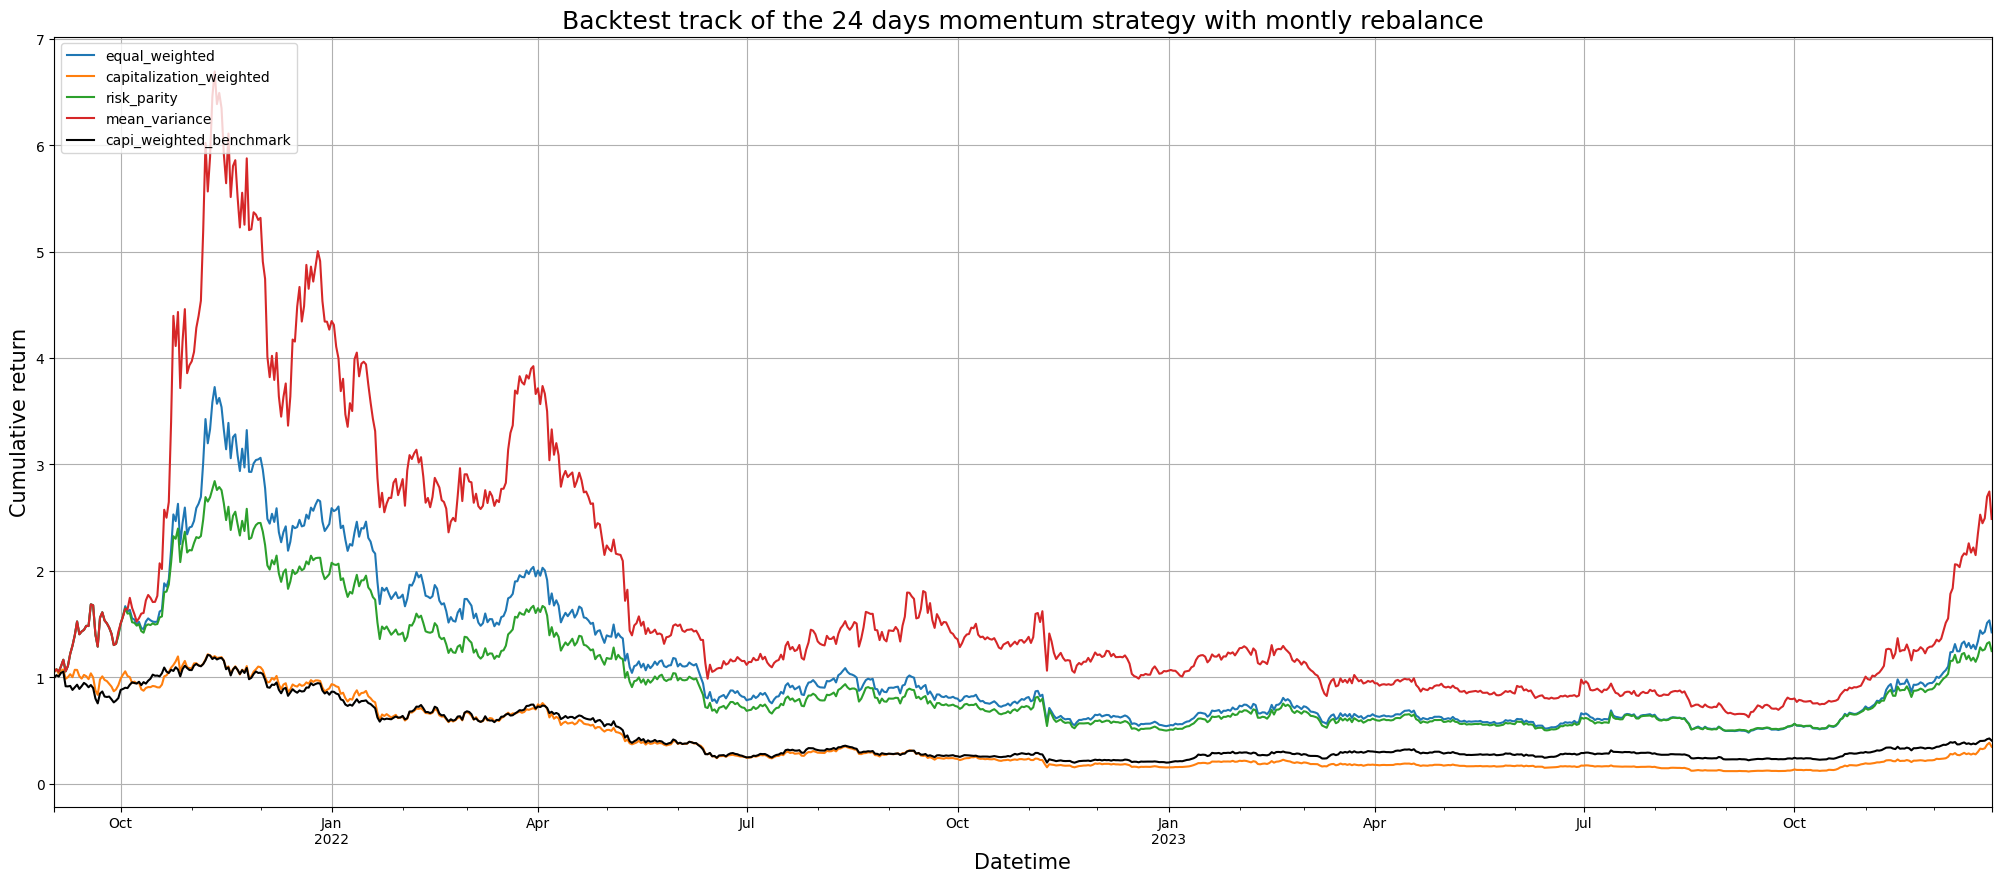

In [8]:
ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="black",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

### Plot one strategy

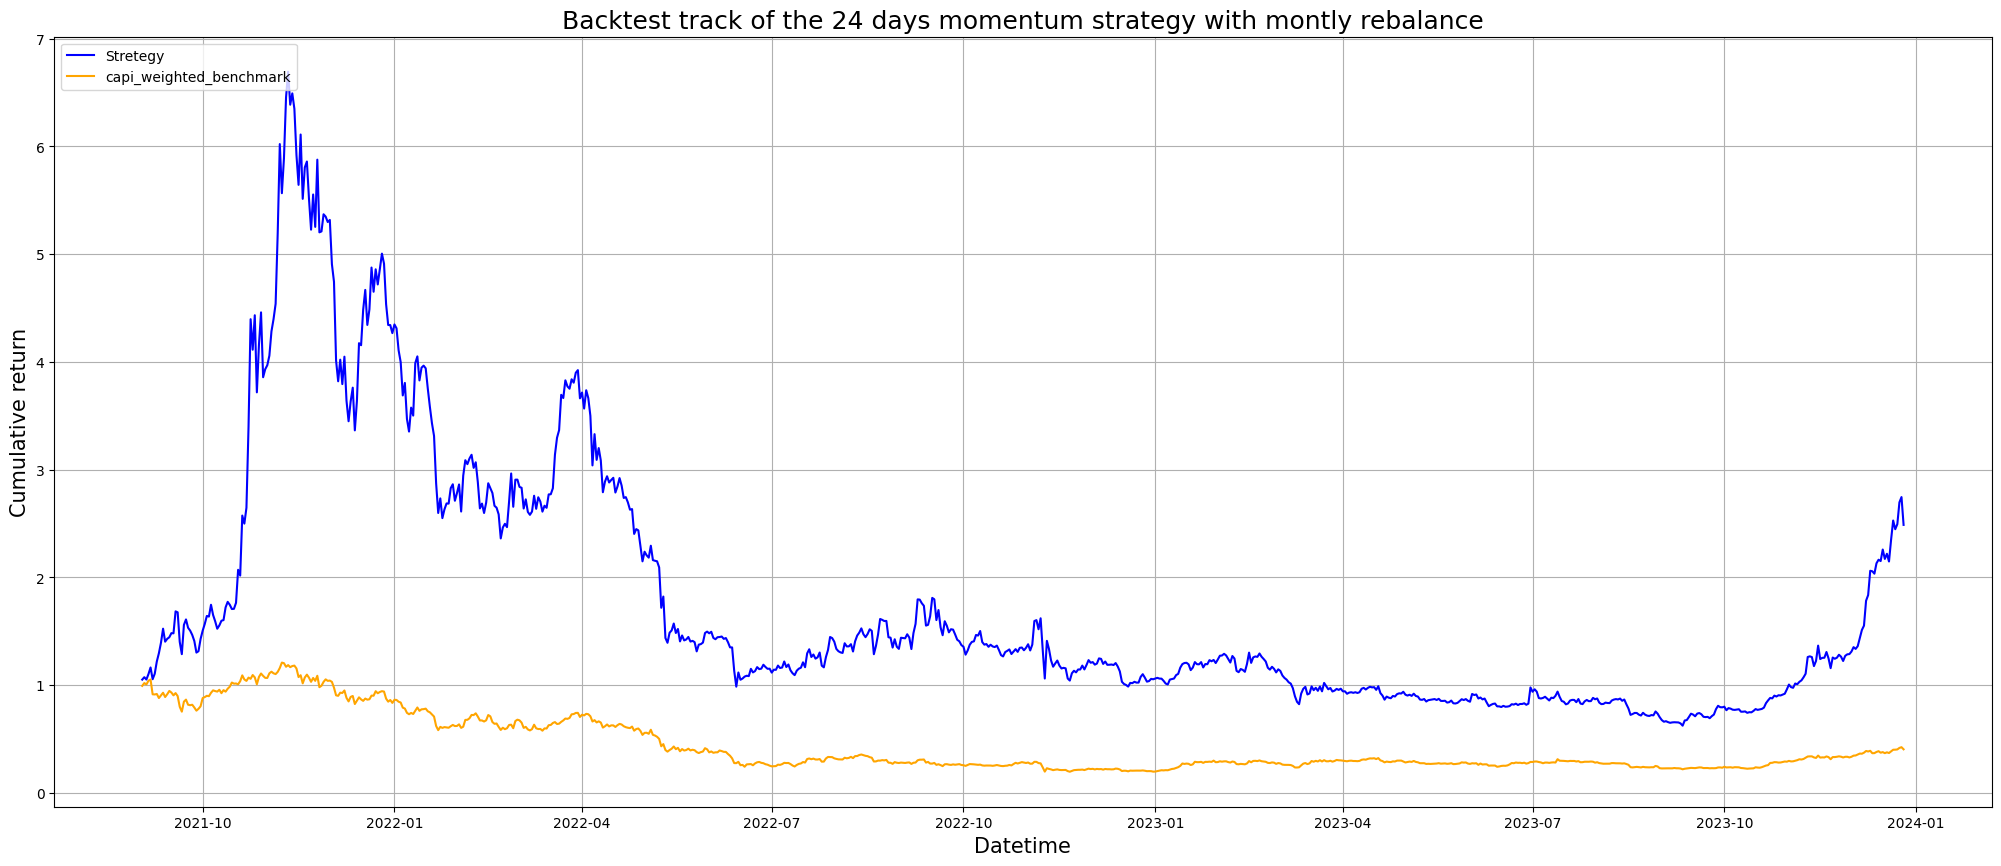

In [9]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    (returns_df["mean_variance"] + 1).cumprod(),
    label="Stretegy",
    color="blue",
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="orange",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

ax.grid()

## Weights analysis


In [10]:
weights_df

,SOL-USDT,AVAX-USDT,KDA-USDT,ADA-USDT,ATOM-USDT,XTZ-USDT,MATIC-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,...,LTC-USDT,XRP-USDT,LINK-USDT,ETC-USDT,BCH-USDT,VET-USDT,EOS-USDT,DASH-USDT,TRX-USDT,XLM-USDT
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-02,0.200000,0.200000,0.200000,0.200000,0.200000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-03,0.218929,0.211923,0.194307,0.195088,0.179753,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-04,0.244525,0.199933,0.188423,0.191326,0.175794,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-05,0.237097,0.209549,0.185642,0.186263,0.181449,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-06,0.231224,0.204335,0.199011,0.182901,0.182530,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.206576,0.284251,0.000000,0.217403,0.000000,0.0,0.0,0.0,0.154051,0.0,...,0.0,0.0,0.137720,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-23,0.210634,0.279342,0.000000,0.214222,0.000000,0.0,0.0,0.0,0.154978,0.0,...,0.0,0.0,0.140825,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-24,0.214569,0.280644,0.000000,0.208528,0.000000,0.0,0.0,0.0,0.152267,0.0,...,0.0,0.0,0.143993,0.0,0.0,0.0,0.0,0.0,0.0,0.0
